Creating Lables for our Model

In [16]:
import pandas as pd

df = pd.read_csv("updated-with-stopwords-expressen-kronikor.csv")
df = df[df['author'].map(df['author'].value_counts()) > 10]
df = df[df['author'] != 'Amina Manzoor']
author_names = df["author"].unique()
labels = {}
index = 0
for author in author_names:
  labels[author] = index
  index += 1


In [17]:
import torch
import numpy as np
from transformers import BertTokenizer
import pandas as pd

# Load in the tokenizer for BERT with pretrained swedish
tokenizer = BertTokenizer.from_pretrained('KB/bert-base-swedish-cased')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['author']]
        self.texts = [tokenizer.encode_plus(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['content']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

Tokenizer, can only take in 512 tokens as maximum, taking the middle of text instead of truncating (Experiment, was not used in the end result)

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_valid_index in split.split(df, df.author):
    df_train = df.iloc[train_index]
    test_valid_set = df.iloc[test_valid_index]

split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for test_index, valid_index in split2.split(test_valid_set, test_valid_set.author):
    df_test = test_valid_set.iloc[test_index]
    df_val = test_valid_set.iloc[valid_index]

print(len(df_train),len(df_val), len(df_test))

682 86 85


In [4]:
def get_split(text):
  l_total = []
  l_parcial = []
  if len(text.split())//150 >0:
    n = len(text.split())//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text.split()[:200]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text.split()[w*150:w*150 + 200]
      l_total.append(" ".join(l_parcial))
  return l_total

df_train['text_split'] = df_train['content'].apply(get_split)
df_val['text_split'] = df_val['content'].apply(get_split)
df_test['text_split'] = df_test['content'].apply(get_split)

def create_new_df(df):
  new_df = pd.DataFrame(columns=["author", "content"])
  i = 0
  for idx, row in df.iterrows():
    for text in row['text_split']:
      new_df.loc[i] = [row.author, text]
      i += 1
  return new_df

df_train_split = create_new_df(df_train)
df_val_split = create_new_df(df_val)
df_test_split = create_new_df(df_test)

C:\Users\Hannes\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Hannes\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Hannes\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [19]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('KB/bert-base-swedish-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, len(labels))
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [23]:
from torch.optim import Adam
from tqdm import tqdm
from pytorchtools import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight


def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=8, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=8)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # The data is imbalanced, to fix it we compute class weights for the labels in the train set 
    # and then pass these weights to the loss function so that it takes care of the class imbalance
    #compute the class weights
    class_weights = compute_class_weight('balanced', np.unique(train_data["author"]), train_data["author"])
    weights= torch.tensor(class_weights,dtype=torch.float)
    weights = weights.to(device)

    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = Adam(model.parameters(), lr= learning_rate)

    avg_train_losses = []
    avg_valid_losses = [] 

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=3, verbose=True)
    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for _ in range(epochs):

            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):
                optimizer.zero_grad()

                train_label = train_label.type(torch.LongTensor).to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()

                batch_loss.backward()
                optimizer.step()

            total_loss_val = 0

            with torch.no_grad():
                
                for val_input, val_label in val_dataloader:

                    val_label = val_label.type(torch.LongTensor).to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()

            avg_train_losses.append(total_loss_train / len(train_data))
            avg_valid_losses.append(total_loss_val / len(val_data))
            early_stopping(avg_valid_losses[-1], model)


            # Check if we have passed the patience limit
            if early_stopping.early_stop:
                print("Early stopping")
                break
    model.load_state_dict(torch.load('checkpoint.pt'))
    return  model, avg_train_losses, avg_valid_losses
epochs = 30
model = BertClassifier()
lr = 1e-5
model, train_loss, valid_loss = train(model, df_train, df_val, lr, epochs)

Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\Hannes\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=['Anders Björkman' 'Anna Bäsén' 'Anna Fri

Validation loss decreased (inf --> 0.391401).  Saving model ...


100%|██████████| 86/86 [01:10<00:00,  1.22it/s]


Validation loss decreased (0.391401 --> 0.325278).  Saving model ...


100%|██████████| 86/86 [01:10<00:00,  1.22it/s]


Validation loss decreased (0.325278 --> 0.254721).  Saving model ...


100%|██████████| 86/86 [01:11<00:00,  1.21it/s]


Validation loss decreased (0.254721 --> 0.199076).  Saving model ...


100%|██████████| 86/86 [01:10<00:00,  1.21it/s]


Validation loss decreased (0.199076 --> 0.157455).  Saving model ...


100%|██████████| 86/86 [01:11<00:00,  1.21it/s]


Validation loss decreased (0.157455 --> 0.123396).  Saving model ...


100%|██████████| 86/86 [01:11<00:00,  1.21it/s]


Validation loss decreased (0.123396 --> 0.105426).  Saving model ...


100%|██████████| 86/86 [01:11<00:00,  1.21it/s]


Validation loss decreased (0.105426 --> 0.093212).  Saving model ...


100%|██████████| 86/86 [01:10<00:00,  1.22it/s]


Validation loss decreased (0.093212 --> 0.078433).  Saving model ...


100%|██████████| 86/86 [01:10<00:00,  1.21it/s]


Validation loss decreased (0.078433 --> 0.069911).  Saving model ...


100%|██████████| 86/86 [01:12<00:00,  1.18it/s]


Validation loss decreased (0.069911 --> 0.064845).  Saving model ...


  0%|          | 0/86 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 3


  0%|          | 0/86 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 3


100%|██████████| 86/86 [01:14<00:00,  1.16it/s]


Validation loss decreased (0.064845 --> 0.062848).  Saving model ...


100%|██████████| 86/86 [01:13<00:00,  1.17it/s]


Validation loss decreased (0.062848 --> 0.061968).  Saving model ...


  0%|          | 0/86 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 3


  0%|          | 0/86 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 3


100%|██████████| 86/86 [01:13<00:00,  1.16it/s]


Validation loss decreased (0.061968 --> 0.058393).  Saving model ...


  0%|          | 0/86 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 3


  0%|          | 0/86 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 3


100%|██████████| 86/86 [01:13<00:00,  1.17it/s]


EarlyStopping counter: 3 out of 3
Early stopping


In [24]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix'
                          ,
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig('bert_updated_newest.pdf')

Classification 11Report:
                       precision    recall  f1-score   support

            Magda Gad       1.00      0.50      0.67         2
          Irena Pozar       0.60      0.75      0.67         4
       Johan Hakelius       1.00      1.00      1.00         3
     Jennifer Wegerup       0.60      0.75      0.67         4
         Cissi Wallin       1.00      0.50      0.67         2
      Britta Svensson       1.00      1.00      1.00         4
     Fredrik Sjöshult       1.00      1.00      1.00         3
           Anna Bäsén       1.00      1.00      1.00         3
        Frida Stranne       1.00      1.00      1.00         4
      Magnus Falkehed       1.00      0.67      0.80         3
        Lotta Gröning       0.50      0.50      0.50         2
        Kassem Hamadé       0.67      1.00      0.80         4
         Mats Larsson       1.00      0.67      0.80         3
       Lars Lindström       0.75      0.75      0.75         4
      Magnus Alselind       1

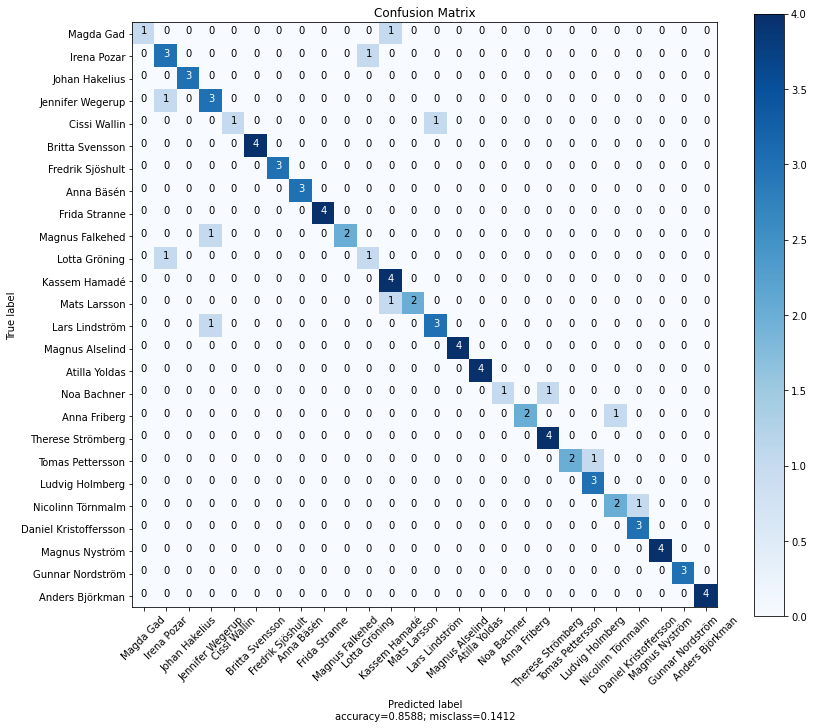

<Figure size 432x288 with 0 Axes>

In [25]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

def evaluate(model, test_data):

    test = Dataset(test_data)
    y_pred = []
    y_true = []
 
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=8)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    with torch.no_grad():

        model.eval()

        for test_input, test_label in test_dataloader:

              test_label = test_label.type(torch.LongTensor).to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)
              y_pred.extend(torch.argmax(output, 1).tolist())
              y_true.extend(test_label.tolist())
    print('Classification Report:')
    cm = classification_report(y_true, y_pred, target_names=labels.keys())
    print(cm)
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, labels, normalize=False, title='Confusion Matrix')
evaluate(model, df_test)


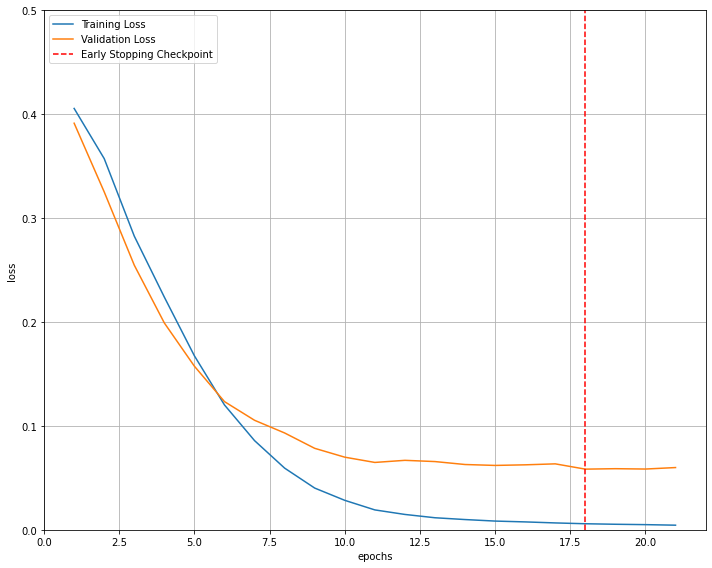

In [26]:
import matplotlib.pyplot as plt
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot_updated.png', bbox_inches='tight')